In [1]:
%matplotlib inline


# 8 - Joint probabilistic data association tutorial


When we have multiple targets we're going to want to arrive at a globally-consistent collection
of associations for PDA, in much the same way as we did for the global nearest neighbour
associator. This is the purpose of the *joint* probabilistic data association (JPDA) filter.

Similar to the PDA, the JPDA algorithm calculates hypothesis pairs for every measurement
for every track. The weight of a track-measurement hypothesis is calculated by the normalised sum
of conditional probabilities that every other track is associated to every other measurement
(including missed detection). For example, with 3 tracks $(A, B, C)$ and 3 measurements
$(x, y, z)$ (including missed detection $None$), the probability of track $A$
being associated with measurement $x$ ($A \to x$) is given by:

\begin{align}p(A \to x) &= \bar{p}(A \to x \cap B \to y \cap C \to z)\\
                 &+ \bar{p}(A \to x \cap B \to z \cap C \to y) +\\
                 &+ \bar{p}(A \to x \cap B \to None \cap C \to z) +\\
                 &+ \bar{p}(A \to x \cap B \to None \cap C \to y) + ...\end{align}

where $\bar{p}(multi-hypothesis)$ is the normalised probability of the multi-hypothesis.



## Simulate ground truth
As with the multi-target data association tutorial, we simulate two targets moving in the
positive x, y cartesian plane (intersecting approximately half-way through their transition).
We then add truth detections with clutter at each time-step.



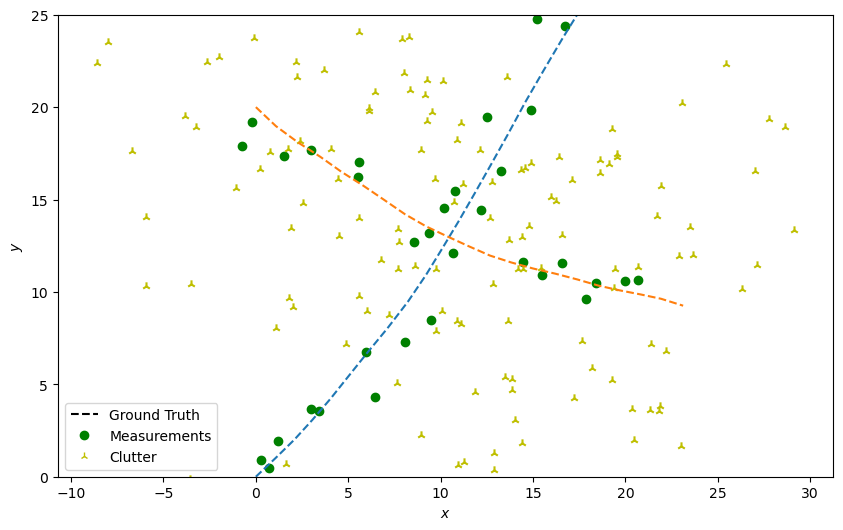

In [2]:
from datetime import datetime
from datetime import timedelta
import numpy as np
from scipy.stats import uniform

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter
from stonesoup.models.measurement.linear import LinearGaussian

np.random.seed(1991)

truths = set()

start_time = datetime.now()
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])

truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])
for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))
truths.add(truth)

truth = GroundTruthPath([GroundTruthState([0, 1, 20, -1], timestamp=start_time)])
for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))
truths.add(truth)

# Plot ground truth.
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.ax.set_ylim(0, 25)
plotter.plot_ground_truths(truths, [0, 2])

# Generate measurements.
all_measurements = []

measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.75, 0],
                          [0, 0.75]])
    )

prob_detect = 0.9  # 90% chance of detection.

for k in range(20):
    measurement_set = set()

    for truth in truths:
        # Generate actual detection from the state with a 10% chance that no detection is received.
        if np.random.rand() <= prob_detect:
            measurement = measurement_model.function(truth[k], noise=True)
            measurement_set.add(TrueDetection(state_vector=measurement,
                                              groundtruth_path=truth,
                                              timestamp=truth[k].timestamp,
                                              measurement_model=measurement_model))

        # Generate clutter at this time-step
        truth_x = truth[k].state_vector[0]
        truth_y = truth[k].state_vector[2]
        for _ in range(np.random.randint(10)):
            x = uniform.rvs(truth_x - 10, 20)
            y = uniform.rvs(truth_y - 10, 20)
            measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=truth[k].timestamp,
                                        measurement_model=measurement_model))
    all_measurements.append(measurement_set)

# Plot true detections and clutter.
plotter.plot_measurements(all_measurements, [0, 2], color='g')

In [3]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

In [4]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

Initial hypotheses are calculated (per track) in the same manner as the PDA.
Therefore, in Stone Soup, the JPDA filter uses the :class:`~.PDAHypothesiser` to create these
hypotheses.
Unlike the :class:`~.PDA` data associator, in Stone Soup, the :class:`~.JPDA` associator takes
this collection of hypotheses and adjusts their weights according to the method described above,
before returning key-value pairs of tracks and detections to be associated with them.



In [5]:
from stonesoup.hypothesiser.probability import PDAHypothesiser
# This doesn't need to be created again, but for the sake of visualising the process, it has been
# added.
hypothesiser = PDAHypothesiser(predictor=predictor,
                               updater=updater,
                               clutter_spatial_density=0.125,
                               prob_detect=prob_detect)

from stonesoup.dataassociator.probability import JPDA
data_associator = JPDA(hypothesiser=hypothesiser)

## Running the JPDA filter



In [6]:
from stonesoup.types.state import GaussianState
from stonesoup.types.track import Track
from stonesoup.types.array import StateVectors
from stonesoup.functions import gm_reduce_single
from stonesoup.types.update import GaussianStateUpdate

prior1 = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)
prior2 = GaussianState([[0], [1], [20], [-1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

tracks = {Track([prior1]), Track([prior2])}

for n, measurements in enumerate(all_measurements):
    hypotheses = data_associator.associate(tracks,
                                           measurements,
                                           start_time + timedelta(seconds=n))

    # Loop through each track, performing the association step with weights adjusted according to
    # JPDA.
    for track in tracks:
        track_hypotheses = hypotheses[track]

        posterior_states = []
        posterior_state_weights = []
        for hypothesis in track_hypotheses:
            if not hypothesis:
                posterior_states.append(hypothesis.prediction)
            else:
                posterior_state = updater.update(hypothesis)
                posterior_states.append(posterior_state)
            posterior_state_weights.append(hypothesis.probability)

        means = StateVectors([state.state_vector for state in posterior_states])
        covars = np.stack([state.covar for state in posterior_states], axis=2)
        weights = np.asarray(posterior_state_weights)

        # Reduce mixture of states to one posterior estimate Gaussian.
        post_mean, post_covar = gm_reduce_single(means, covars, weights)

        # Add a Gaussian state approximation to the track.
        track.append(GaussianStateUpdate(
            post_mean, post_covar,
            track_hypotheses,
            track_hypotheses[0].measurement.timestamp))

Plot the resulting tracks.



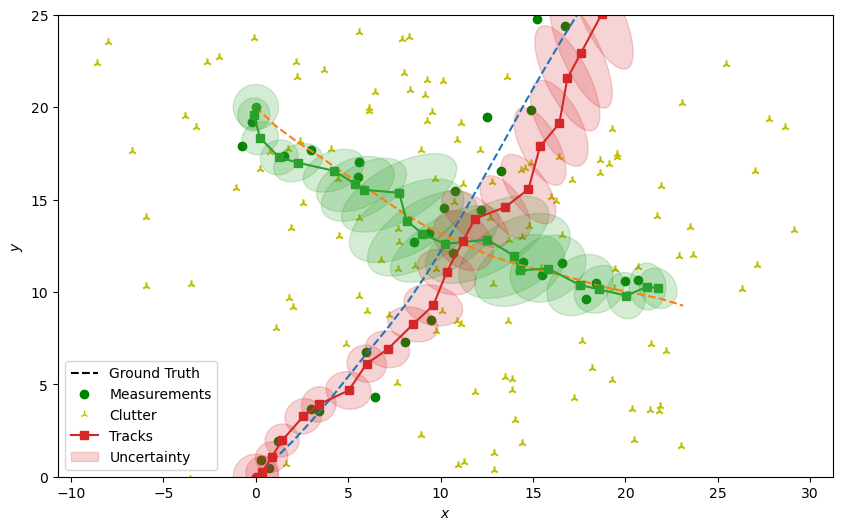

In [7]:
plotter.plot_tracks(tracks, [0, 2], uncertainty=True)
plotter.fig

## References
1. Bar-Shalom Y, Daum F, Huang F 2009, The Probabilistic Data Association Filter, IEEE Control
Systems Magazine

